In [75]:
import numpy as np
import torch
import cv2
import matplotlib.pyplot as plt
import os
import multiprocessing as mp
import seaborn as sns

from code.models import basicunet, resnetunet
from code.datasets import TGSTTADataset
from code.configs import *
from code.train import *
from code.losses import FocalRobustLoss
from code.metrics import *
from code.augmentations import *
from code.utils import *
from torch.utils.data import DataLoader
from IPython.display import clear_output
from code.inference import *

%matplotlib inline

In [2]:
def test_postproc(image, mask):
    image, mask = do_resize2(image, mask, 202, 202)
    image, mask = do_center_pad_to_factor2(image, mask, factor=64)
    return image, mask

In [3]:
class UNetResNet34Wrapped(resnetunet.UNetResNet34):
    
    def __init__(self, device):
        super().__init__()
        self.device = device
        self.to(device)
        
    def __call__(self, image, **kwargs):
        logits = super().__call__(image)
        return {"logits": logits[:,0]}

In [4]:
test_ds = TGSTTADataset(postproc=test_postproc, path=PATH_TO_TEST, 
                        path_to_depths=PATH_TO_DEPTHS, progress_bar=True)
test_dl = DataLoader(test_ds, batch_size=16, num_workers=4)

In [5]:
device = torch.device("cuda")
model = UNetResNet34Wrapped(device)
mAP_cp = BestLastCheckpointer("mAP1")
mAP_cp.load("best", model=model)
predict_and_save(model, test_dl, ["logits"], "id", "test1", verbose=1)

/usr/local/lib/python3.5/dist-packages/torch/nn/functional.py:1890: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


In [6]:
device = torch.device("cuda")
model = UNetResNet34Wrapped(device)
mAP_cp = BestLastCheckpointer("mAP2")
mAP_cp.load("best", model=model)
predict_and_save(model, test_dl, ["logits"], "id", "test2", verbose=1)

/usr/local/lib/python3.5/dist-packages/torch/nn/functional.py:1890: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


In [7]:
device = torch.device("cuda")
model = UNetResNet34Wrapped(device)
mAP_cp = BestLastCheckpointer("mAP3")
mAP_cp.load("best", model=model)
predict_and_save(model, test_dl, ["logits"], "id", "test3", verbose=1)

/usr/local/lib/python3.5/dist-packages/torch/nn/functional.py:1890: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


In [8]:
device = torch.device("cuda")
model = UNetResNet34Wrapped(device)
mAP_cp = BestLastCheckpointer("mAP4")
mAP_cp.load("best", model=model)
predict_and_save(model, test_dl, ["logits"], "id", "test4", verbose=1)

/usr/local/lib/python3.5/dist-packages/torch/nn/functional.py:1890: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


In [9]:
device = torch.device("cuda")
model = UNetResNet34Wrapped(device)
mAP_cp = BestLastCheckpointer("mAP5")
mAP_cp.load("best", model=model)
predict_and_save(model, test_dl, ["logits"], "id", "test5", verbose=1)

/usr/local/lib/python3.5/dist-packages/torch/nn/functional.py:1890: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


In [66]:
dirs = ["test1/logits/", "test2/logits/", "test3/logits/", "test4/logits/", "test5/logits/"]
logits, ids = [], []

for name in os.listdir(dirs[0]):
    name = name.split(".")[0]
    id_ = name.split("_")[0]
    ids.append(id_)
    
ids = list(set(ids))
    
for id_ in tqdm_notebook(ids):
    logit_list = []
    for dirname in dirs:
        suffix = ""
        name = id_ + suffix + ".npy"
        path = os.path.join(dirname, name)
        logit = np.load(path)
        logit_list.append(logit)
        
        suffix = "_flipped"
        name = id_ + suffix + ".npy"
        path = os.path.join(dirname, name)
        logit = np.load(path)
        logit = logit[:,::-1]
        logit_list.append(logit)
        
    logit = np.mean(np.array(logit_list), axis=0)
    logit = logit[27:-27,27:-27]
    logit = cv2.resize(logit, dsize=(101, 101))
    logits.append(logit)
logits = np.array(logits)

In [67]:
logits.shape, len(ids)

((18000, 101, 101), 18000)

In [68]:
preds = (logits > 0).astype(int)

In [69]:
preds = force_zero_empty(os.path.join(PATH_TO_TEST, "images"), ids, preds, verbose=1)

In [70]:
prepare_submit(preds, ids, "smbt37.csv")

In [71]:
!kaggle competitions submit -c tgs-salt-identification-challenge -f smbt37.csv -m "ResNet34 Lovasz 5 fold flip tta"

Successfully submitted to TGS Salt Identification Challenge

In [85]:
with open("ids.pkl", "rb") as f:
    ids2 = pickle.load(f)

In [89]:
sum = preds.sum(axis=(1, 2))

In [99]:
preds2 = preds
preds2[sum < 10] = 0
prepare_submit(preds2, ids, "smbt38.csv")

In [100]:
!kaggle competitions submit -c tgs-salt-identification-challenge -f smbt38.csv -m "ResNet34; Lovaszl 5 fold; flip tta; less 10 to zero;"

Successfully submitted to TGS Salt Identification Challenge

In [101]:
cv2.connectedComponents(preds[0])

error: OpenCV(3.4.2) /io/opencv/modules/imgproc/src/connectedcomponents.cpp:3936: error: (-215:Assertion failed) iDepth == 0 || iDepth == 1 in function 'connectedComponents_sub1'


In [111]:
imgs = np.array([cv2.imread(os.path.join(PATH_TO_TRAIN, "images", name))[:,:,0] for name in os.listdir(os.path.join(PATH_TO_TRAIN, "images"))])

In [112]:
imgs.shape, imgs.dtype

((4000, 101, 101), dtype('uint8'))

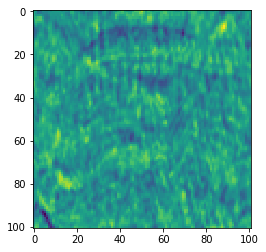

In [134]:
plt.imshow(imgs[1175])

/usr/local/lib/python3.5/dist-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


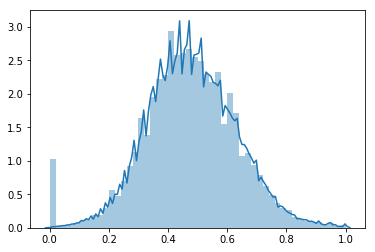

In [106]:
sns.distplot(imgs.flatten())

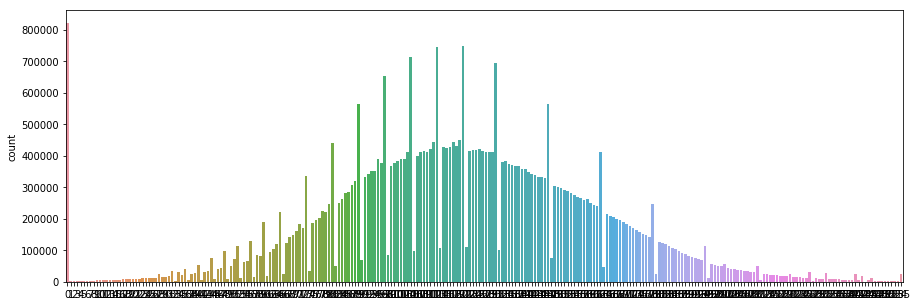

In [114]:
plt.figure(figsize=[15, 5])
sns.countplot(imgs.flatten())

In [129]:
np.arange(len(imgs))[(imgs == 49).any(axis=(1, 2)) & (imgs != 50).all(axis=(1, 2))]

array([  94,  133,  216,  268,  383,  449,  484,  487,  488,  569,  868,
        879,  992, 1024, 1083, 1085, 1175, 2084, 2442, 2584, 2695, 2715,
       2851, 2877, 3090, 3109, 3142, 3224, 3337, 3567, 3569, 3617, 3645,
       3744, 3881, 3923, 3983])